# Exp 019: Decoding-based grammar control
This experiments sets up decoding-strategies for grammar-controlled educational text generation.

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['CACHE_DIR'] = os.environ['FAST_CACHE_DIR'].replace("%SLURM_JOB_ID%", os.getenv('SLURM_JOB_ID')) # speed up model loading

import sys
sys.path.append(f'../source')
import helpers
import models
import importlib
#importlib.reload(models)

import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset, TensorDataset
import torch.nn.functional as F
from transformers import TopKLogitsWarper, LogitsProcessor, EpsilonLogitsWarper, SequenceBiasLogitsProcessor, TopPLogitsWarper
import datasets
datasets.disable_caching()
import pandas as pd
import time
import numpy as np
import json
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import random

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.61758910.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


## Ground-truth partial scoring
For an efficient decoding, partial sequences should already score high. Then, we do not need to train future discriminators anymore.

In [2]:
# params
preprossed_dataset_file = '../data/SFT_data.jsonl'
batch_size=128
max_len = 64
dir = 'partial_sequences' #'corpus_training'

In [27]:
# data
dataset = datasets.load_dataset('json', data_files=preprossed_dataset_file, split='train')

In [34]:
all_constraints = helpers.get_high_conf_classifiers() #list(np.unique(dataset['constraints']))
partial_scores = {}
max_indices = {}

for nr in tqdm(all_constraints, desc="Constraints"):    
    subset = dataset.filter(lambda item: item['constraints']==[nr])
    encoded_inputs = models.bert_tokenizer(subset['response'][:20], return_tensors='pt', max_length=64, padding='max_length', truncation=True)
    partial_scores[nr] = np.zeros(encoded_inputs['input_ids'].shape)
    classifier = models.load_classifier(nr, dir)
    
    for i in tqdm(range(partial_scores[nr].shape[1]), total=partial_scores[nr].shape[1], leave=False, desc="Sequence lengths"):
        corpus_dataset = TensorDataset(encoded_inputs['input_ids'][:,:i+1], encoded_inputs['attention_mask'][:,:i+1])
        corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)
        scores = models.score_corpus(classifier, corpus_dataloader, max_positive=1e10, max_batches=10000, progress=False)
        partial_scores[nr][:,i] = scores[0]
    max_indices[nr] = scores[1] # only save max token for the entire sequence

Constraints:   0%|          | 0/28 [00:00<?, ?it/s]

Filter:   0%|          | 0/234775 [00:00<?, ? examples/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Filter:   0%|          | 0/234775 [00:00<?, ? examples/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Filter:   0%|          | 0/234775 [00:00<?, ? examples/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Filter:   0%|          | 0/234775 [00:00<?, ? examples/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Filter:   0%|          | 0/234775 [00:00<?, ? examples/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Filter:   0%|          | 0/234775 [00:00<?, ? examples/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Filter:   0%|          | 0/234775 [00:00<?, ? examples/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Filter:   0%|          | 0/234775 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [35]:
def get_aligned_scores(scores, max_tokens):
    #threshold_indices = np.argmax(data >= 0.5, axis=1)
    max_index = max(max_tokens)
    target_length = scores.shape[1] + max_index
    padded_data = []
    
    for i, row in enumerate(scores):
        shift = max_index - max_tokens[i]
        padded_row = np.pad(row, (shift, 0), mode='constant', constant_values=(0, 0))
        right_padding = target_length - len(padded_row)
        if right_padding > 0:
            padded_row = np.pad(padded_row, (0, right_padding), mode='constant', constant_values=(0, row[-1]))
        padded_data.append(padded_row)
    
    return np.array(padded_data)

  0%|          | 0/26 [00:00<?, ?it/s]

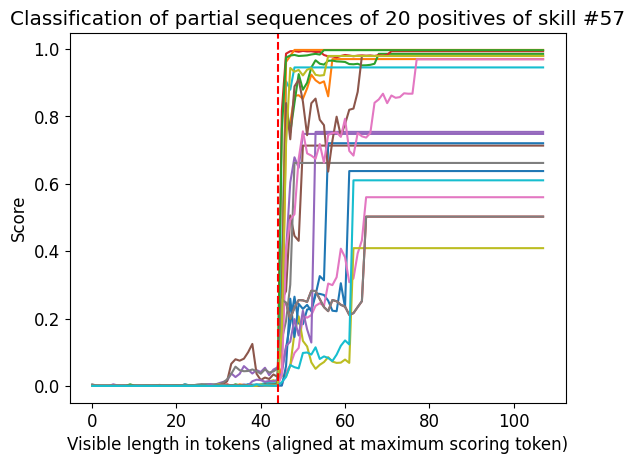

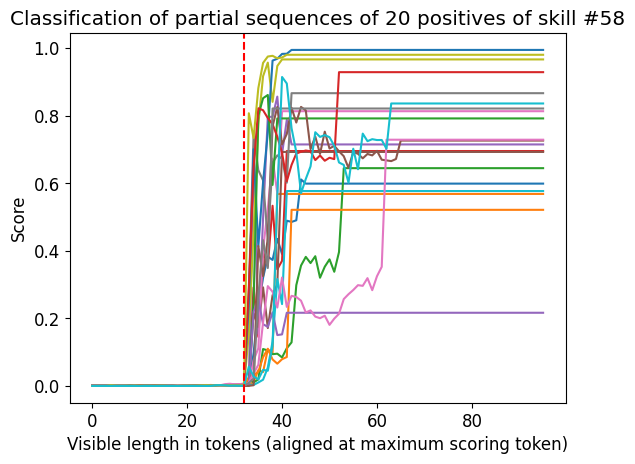

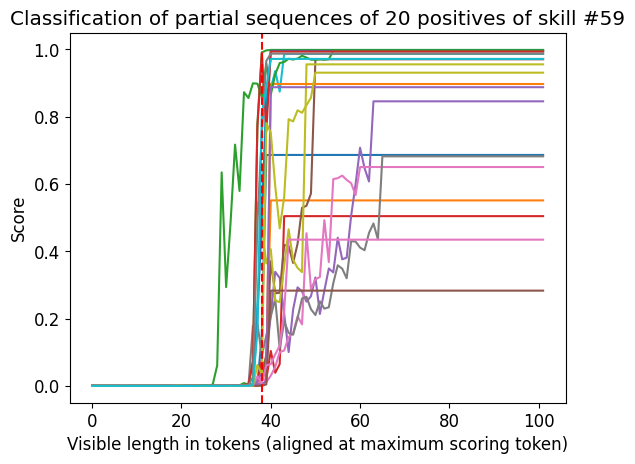

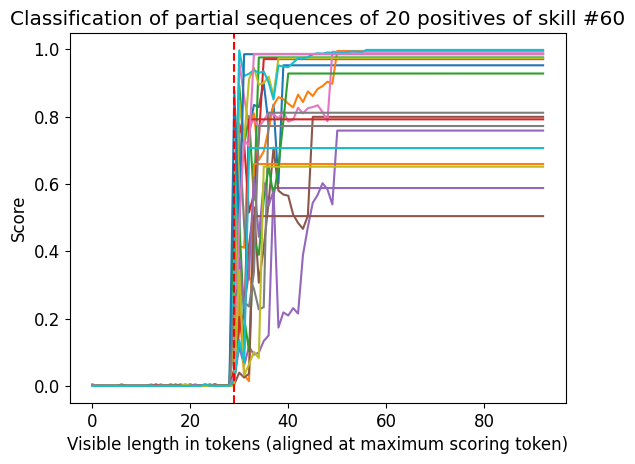

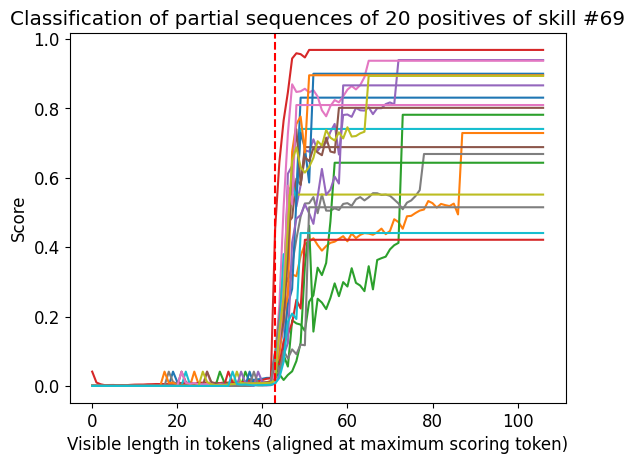

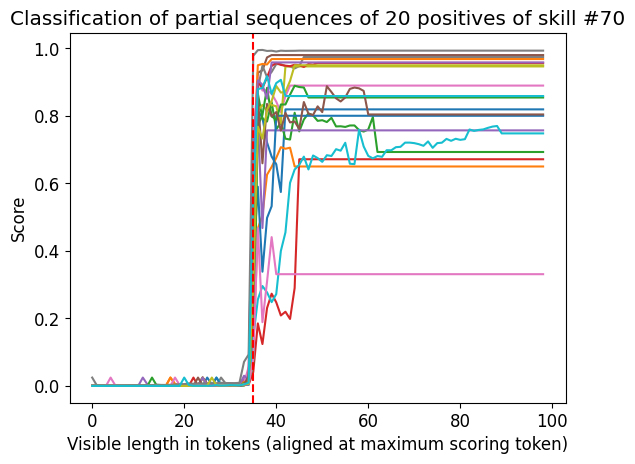

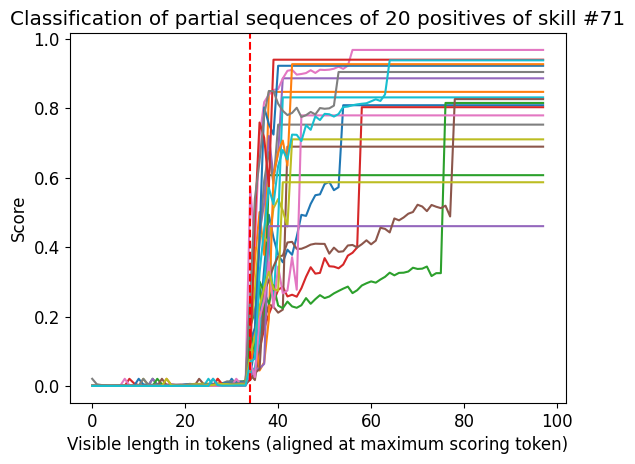

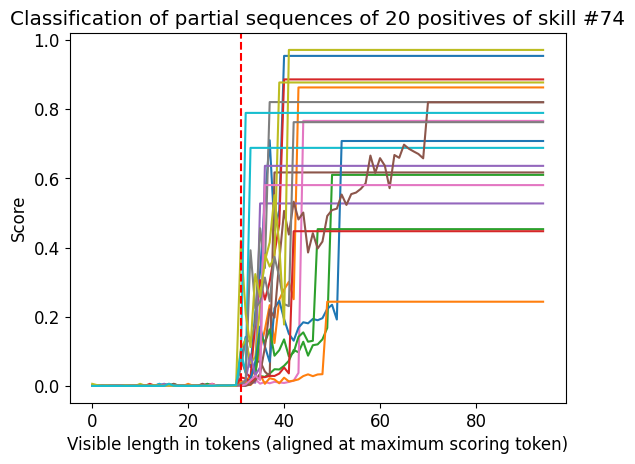

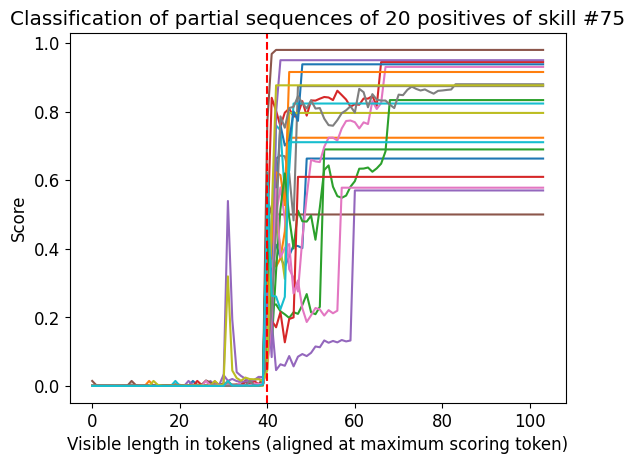

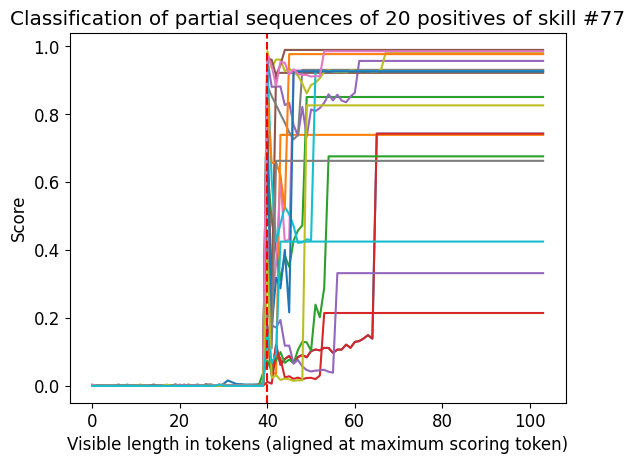

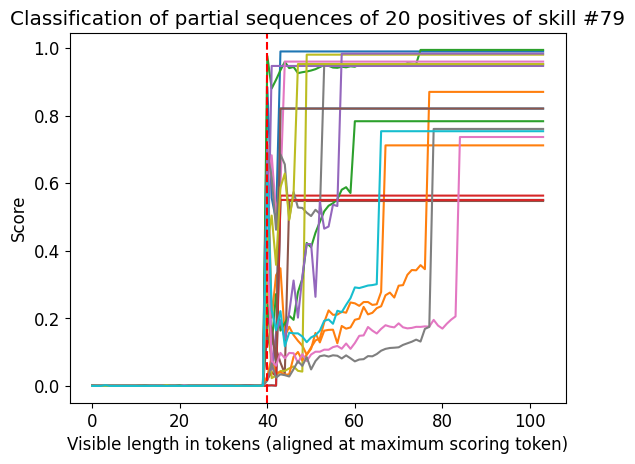

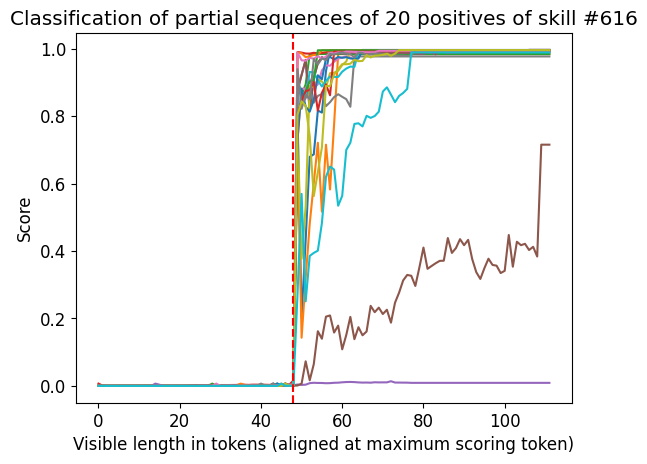

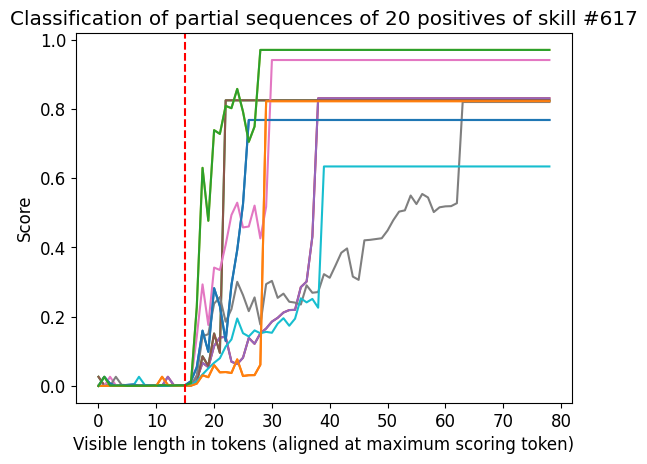

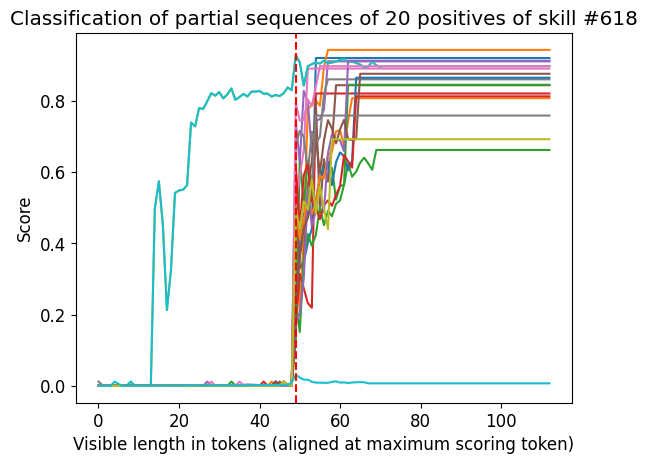

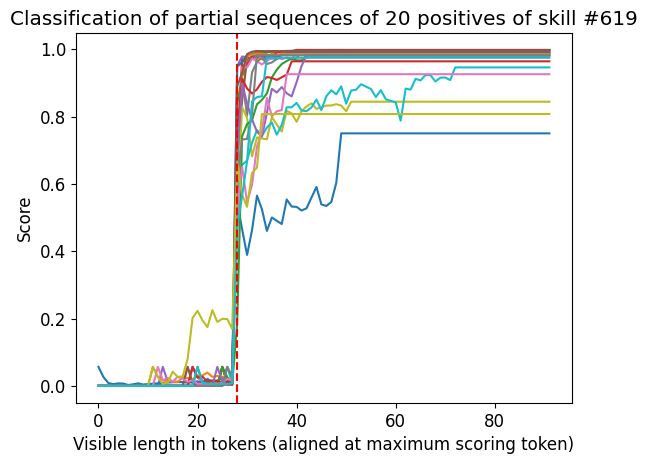

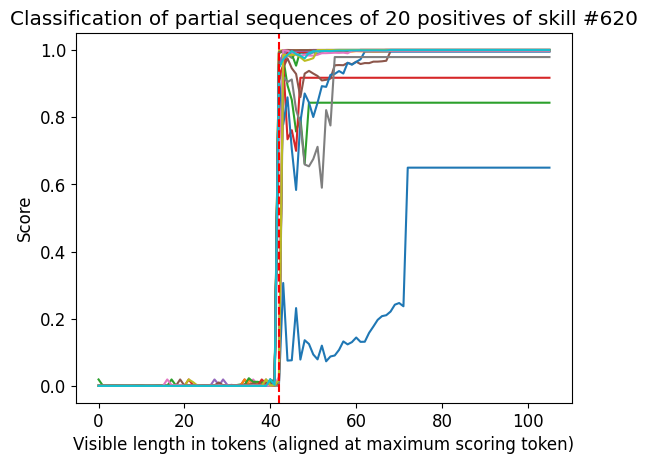

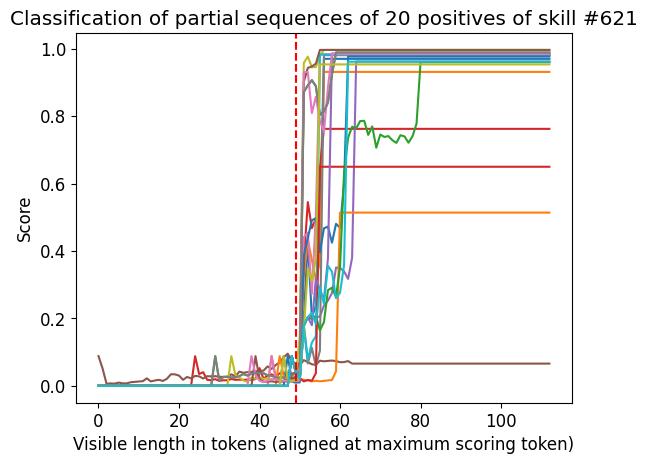

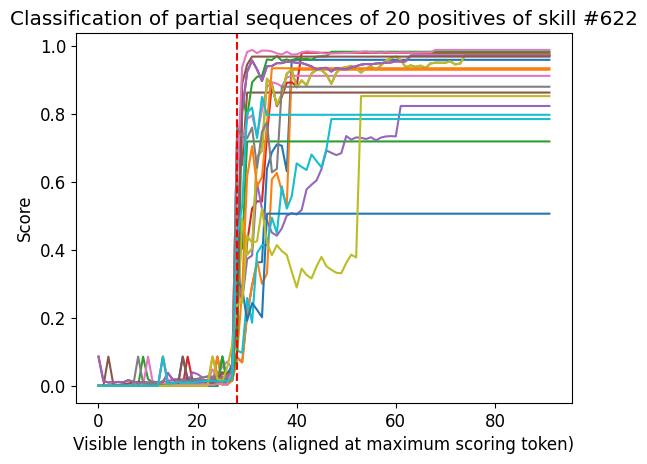

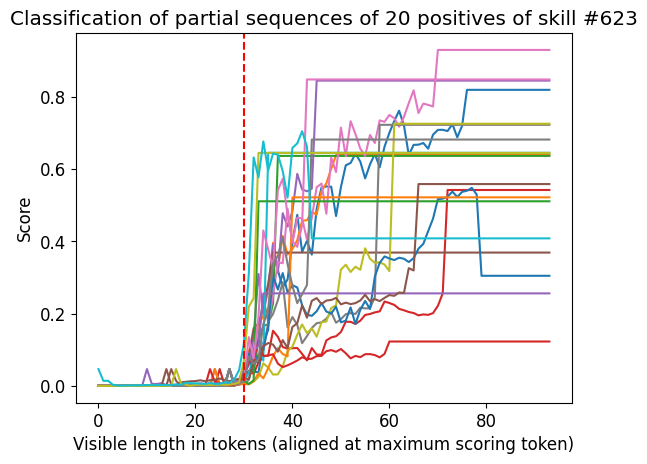

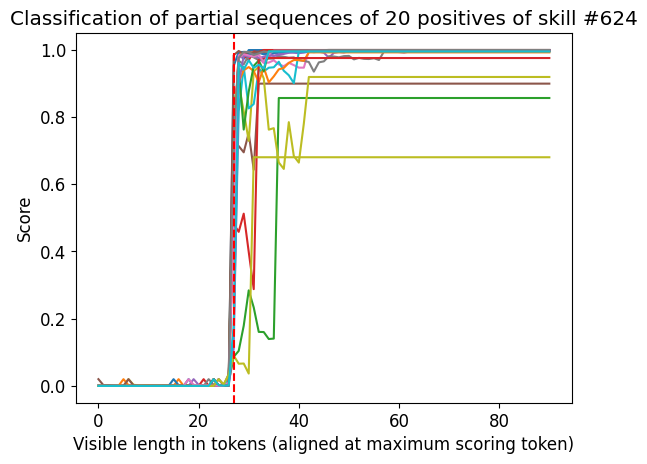

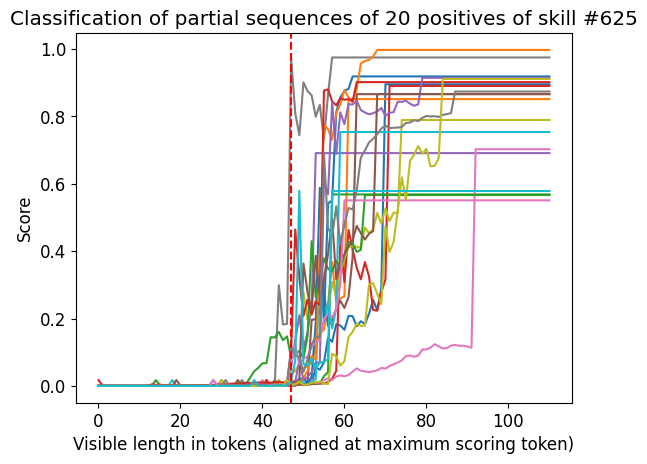

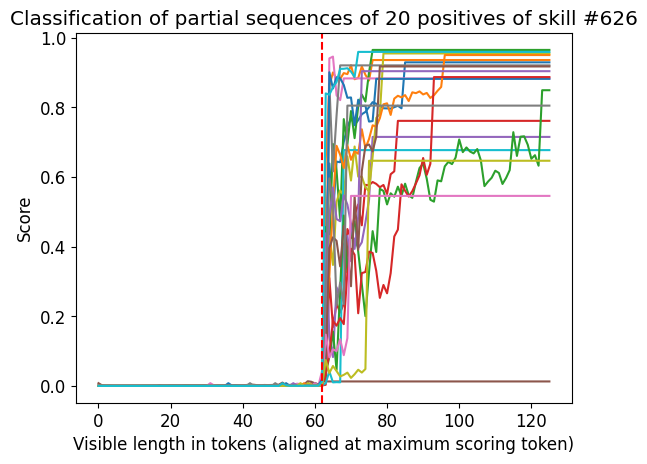

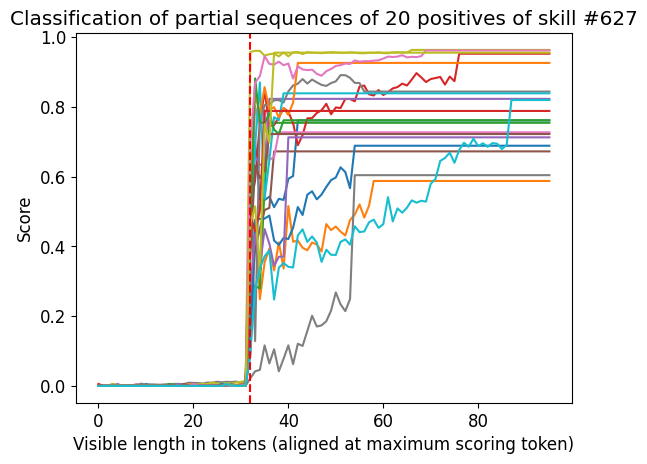

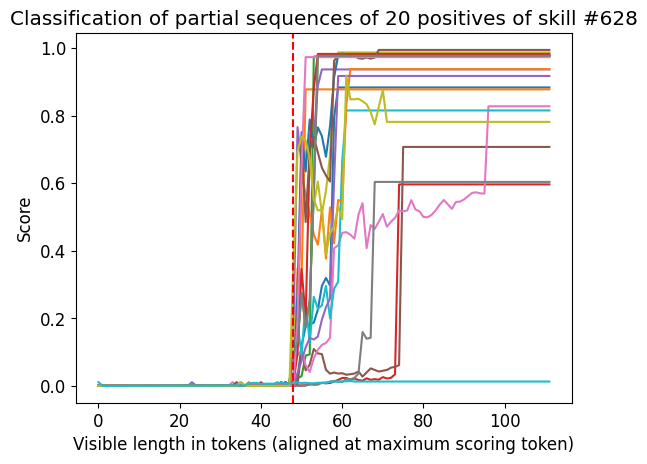

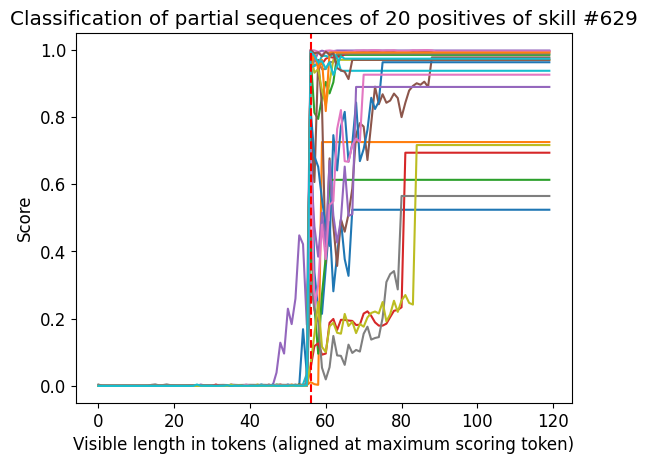

In [41]:
plt.rcParams.update({'font.size': 12})
for (nr, scores), max_tokens in tqdm(zip(partial_scores.items(), max_indices.values()), total=len(partial_scores)):
    #print(max_tokens)
    #plt.plot(get_aligned_scores(scores, max_tokens).mean(axis=0))
    plt.plot(get_aligned_scores(scores,max_tokens)[:20,:].transpose(1,0))
    plt.title(f"Classification of partial sequences of 20 positives of skill #{nr}")
    plt.ylabel("Score")
    plt.axvline(x=max(max_tokens),color='r', linestyle='--')
    plt.xlabel("Visible length in tokens (aligned at maximum scoring token)")
    plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

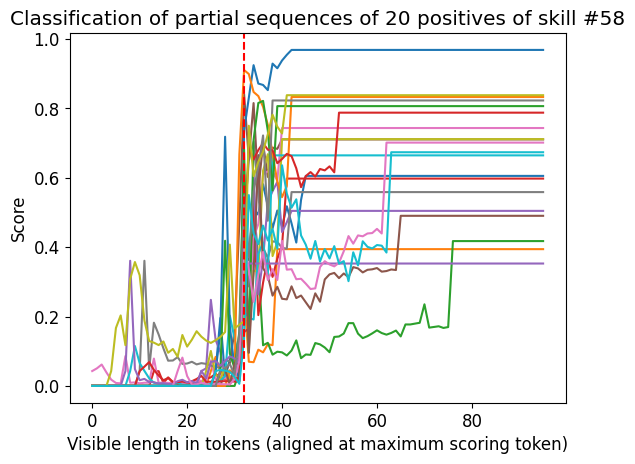

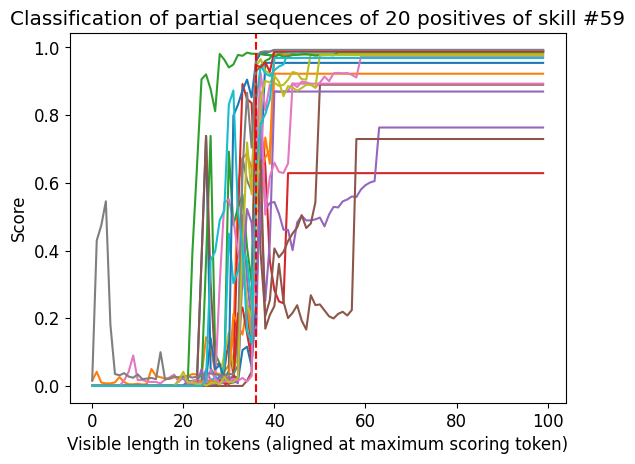

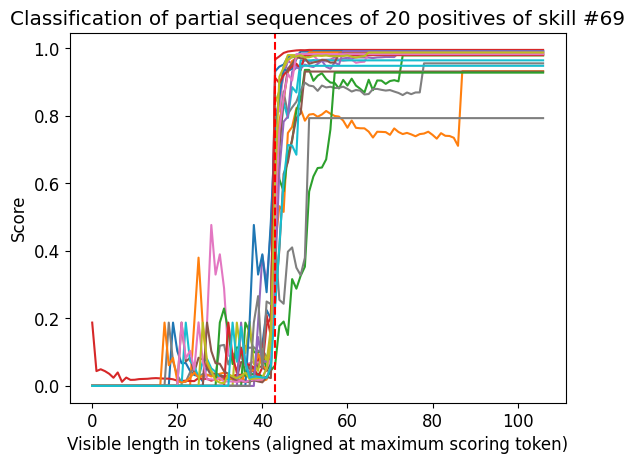

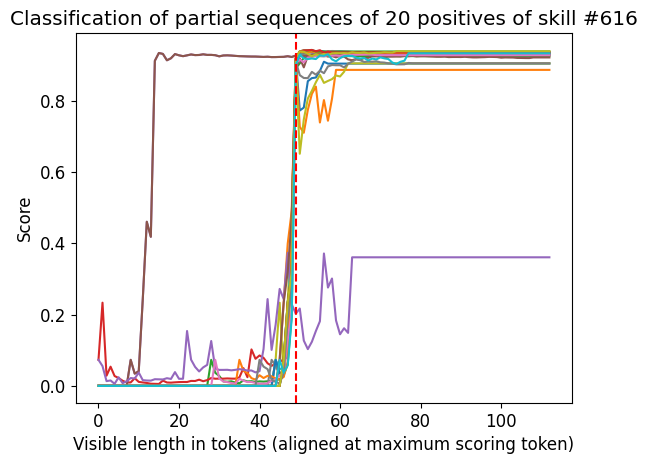

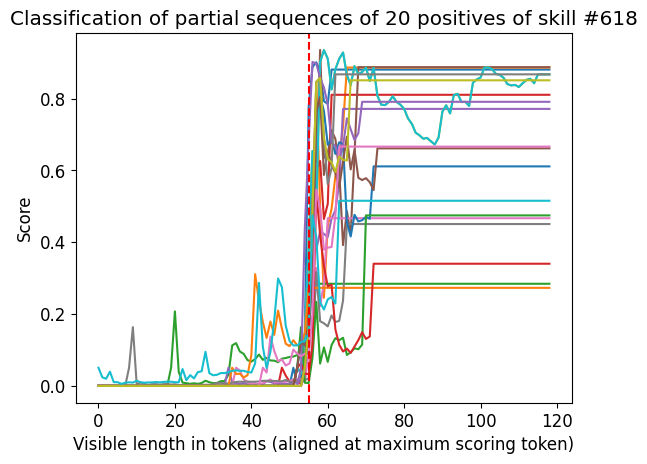

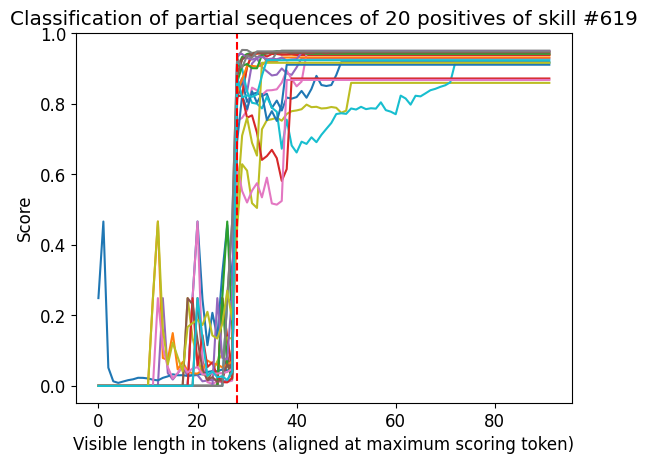

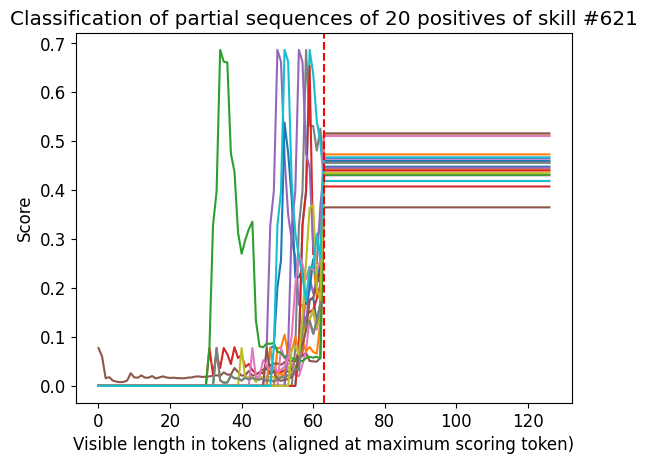

In [36]:
plt.rcParams.update({'font.size': 12})
for (nr, scores), max_tokens in tqdm(zip(partial_scores.items(), max_indices.values()), total=len(partial_scores)):
    #print(max_tokens)
    #plt.plot(get_aligned_scores(scores, max_tokens).mean(axis=0))
    plt.plot(get_aligned_scores(scores,max_tokens)[:20,:].transpose(1,0))
    plt.title(f"Classification of partial sequences of 20 positives of skill #{nr}")
    plt.ylabel("Score")
    plt.axvline(x=max(max_tokens),color='r', linestyle='--')
    plt.xlabel("Visible length in tokens (aligned at maximum scoring token)")
    plt.show()

# Train partial classifiers
The goal is to predict the presence of a grammar construct from partial sentences.

In [8]:
save_dir = 'partial_sequences'
input_path = '../data/annotated_corpus.json'
egp_gpt = pd.read_json("../data/egp_gpt35.json")
max_length=64

In [9]:
instances = pd.read_json(input_path)
sentences = data.get_mixed_sentences(1000000)

def get_instances(nr, positives=True):
    return list(set(instances[(instances['#'] == nr) & (instances['positive']==positives)]['sentence']))
def get_others(nr):
    return list(set(sentences).difference(set(get_instances(nr))))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  7.21s/it]


In [10]:
def pad_to_max_length(input, max_length=64):
    return torch.nn.functional.pad(input, (0, max_length-input.shape[1], 0, 0))

In [11]:
class EncodedSentences(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [12]:
def get_partial_sequences(encoding):
    new_inputs = []
    new_attentions = []
    for length in range(2, encoding['input_ids'].shape[1]):
        subset=encoding['attention_mask'][:,length]==1
        if not subset.sum(): continue
        new_inputs.append(pad_to_max_length(encoding['input_ids'][subset,:length]))
        new_attentions.append(pad_to_max_length(encoding['attention_mask'][subset,:length]))
    return {"input_ids": torch.vstack(new_inputs),
            "attention_mask": torch.vstack(new_attentions)}

def get_partial_dataset(sentences, label):
    encoding = models.bert_tokenizer(sentences, return_tensors='pt', truncation=True, max_length=max_length, padding='max_length')
    partials_encoded = get_partial_sequences(encoding)
    partials_encoded['labels'] = (torch.ones(partials_encoded['input_ids'].shape[0]) * label).int()
    return EncodedSentences(**partials_encoded)

In [13]:
all_metrics = {}
for nr in tqdm(helpers.get_high_conf_classifiers(), desc="EGP constructs"):
    if nr in all_metrics: continue
    positives = get_instances(nr)
    negatives = get_instances(nr, False)
    others = random.sample(get_others(nr), 4 * len(positives))
    dataset = ConcatDataset([get_partial_dataset(positives, 1), get_partial_dataset(negatives, 0), get_partial_dataset(others, 0)])
    train_dataloader, val_dataloader = data.get_loaders(dataset, batch_size=32)
    classifier = models.RuleDetector(models.bert_encoder).to(models.device)
    _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=False)
    # sanity check on given examples
    print(models.probe_model(classifier, egp_gpt[egp_gpt['#']==nr].iloc[0]['Example'].split("\n\n")))
    print(val_metrics)
    all_metrics[nr] = val_metrics
    models.save_classifier(classifier, nr, save_dir)

EGP constructs:   0%|          | 0/31 [00:00<?, ?it/s]


 40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [00:57<01:26, 14.38s/it]


(tensor([0.9865, 0.9845]), ['best', 'best'])
{'accuracy': 0.943, 'f1': 0.778, 'precision': 0.942}



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [00:49<00:12,  6.24s/it]


(tensor([0.9199, 0.9200]), ['biggest', '##iest'])
{'accuracy': 0.927, 'f1': 0.748, 'precision': 0.796}



 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [01:36<00:41, 13.79s/it]


(tensor([0.8768, 0.9071]), ['biggest', '##est'])
{'accuracy': 0.924, 'f1': 0.765, 'precision': 0.758}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.48s/it]


(tensor([0.8665, 0.9443]), ['most', 'most'])
{'accuracy': 0.902, 'f1': 0.689, 'precision': 0.87}



 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [01:23<00:55, 13.96s/it]


(tensor([0.9797, 0.7123]), ['easiest', '##est'])
{'accuracy': 0.923, 'f1': 0.8, 'precision': 0.907}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.51s/it]


(tensor([0.9889, 0.9911, 0.9831]), ['possible', 'possible', 'possible'])
{'accuracy': 0.958, 'f1': 0.854, 'precision': 0.938}



 30%|████████████████████████████████████████▌                                                                                              | 3/10 [00:37<01:27, 12.49s/it]


(tensor([0.9256, 0.8660]), ['d', 'would'])
{'accuracy': 0.935, 'f1': 0.759, 'precision': 0.972}



 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [01:05<01:05, 13.04s/it]


(tensor([0.9432, 0.9610]), ['like', 'like'])
{'accuracy': 0.931, 'f1': 0.787, 'precision': 0.813}



 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [00:42<00:42,  8.57s/it]


(tensor([0.9940, 0.9056]), ['love', 'prefer'])
{'accuracy': 0.886, 'f1': 0.713, 'precision': 0.779}



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [00:48<00:12,  6.10s/it]


(tensor([0.8885, 0.8841, 0.8852]), ['like', 'like', 'like'])
{'accuracy': 0.953, 'f1': 0.793, 'precision': 0.928}



 40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [00:28<00:43,  7.19s/it]


(tensor([0.9583, 0.9514, 0.9776]), ['prefer', 'prefer', 'love'])
{'accuracy': 0.937, 'f1': 0.789, 'precision': 0.892}



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [01:18<00:19,  9.83s/it]


(tensor([0.9244, 0.8993, 0.9687, 0.9359]), ['would', 'd', 'were', 'wouldn'])
{'accuracy': 0.944, 'f1': 0.793, 'precision': 0.941}



 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [01:38<01:38, 19.75s/it]


(tensor([0.8394, 0.7995, 0.3384, 0.3549]), ['would', 'would', 'wouldn', 'wouldn'])
{'accuracy': 0.96, 'f1': 0.806, 'precision': 0.84}



 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [01:19<00:34, 11.42s/it]


(tensor([0.8990, 0.9680, 0.9736]), ['really', 'probably', 'definitely'])
{'accuracy': 0.957, 'f1': 0.831, 'precision': 0.981}



 40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [01:49<02:44, 27.35s/it]


(tensor([0.9938, 0.9952, 0.9939]), ['would', 'would', 'would'])
{'accuracy': 0.961, 'f1': 0.897, 'precision': 0.893}



 40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [00:54<01:21, 13.64s/it]


(tensor([0.8454, 0.9090, 0.9951, 0.9967]), ['have', 'have', 'hadn', 'had'])
{'accuracy': 0.971, 'f1': 0.927, 'precision': 0.945}



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9/10 [01:15<00:08,  8.43s/it]


(tensor([0.9691, 0.8208, 0.8835]), ['said', 'said', 'told'])
{'accuracy': 0.954, 'f1': 0.871, 'precision': 0.834}



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9/10 [01:16<00:08,  8.51s/it]


(tensor([0.9736, 0.9305]), ['wouldn', 'would'])
{'accuracy': 0.963, 'f1': 0.885, 'precision': 0.918}



 30%|████████████████████████████████████████▌                                                                                              | 3/10 [01:01<02:23, 20.52s/it]


(tensor([0.7105, 0.9925]), ['would', 'would'])
{'accuracy': 0.973, 'f1': 0.919, 'precision': 0.924}



 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [01:08<00:45, 11.48s/it]


(tensor([0.9826, 0.9475]), ['if', 'if'])
{'accuracy': 0.955, 'f1': 0.833, 'precision': 0.855}



 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [00:58<00:58, 11.66s/it]


(tensor([0.8746, 0.9491, 0.9075]), ['went', 'went', 'was'])
{'accuracy': 0.951, 'f1': 0.87, 'precision': 0.85}



 30%|████████████████████████████████████████▌                                                                                              | 3/10 [01:00<02:20, 20.04s/it]


(tensor([0.9916, 0.9961, 0.9951]), ['had', 'hadn', 'hadn'])
{'accuracy': 0.974, 'f1': 0.933, 'precision': 0.92}



 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [00:52<00:34,  8.68s/it]


(tensor([0.9706, 0.9568, 0.8754, 0.9770]), ['not', 'not', 'not', 't'])
{'accuracy': 0.911, 'f1': 0.783, 'precision': 0.859}



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [01:11<00:17,  8.94s/it]


(tensor([0.9864, 0.9685]), ['don', 'don'])
{'accuracy': 0.921, 'f1': 0.814, 'precision': 0.842}



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [01:12<00:18,  9.06s/it]


(tensor([0.9924, 0.9966]), ['can', 'can'])
{'accuracy': 0.944, 'f1': 0.844, 'precision': 0.888}



 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [01:46<00:45, 15.21s/it]


(tensor([0.9529, 0.9619, 0.9756, 0.9822, 0.9641]), ['not', 'not', 'haven', 'haven', 'not'])
{'accuracy': 0.938, 'f1': 0.808, 'precision': 0.903}



 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [01:20<00:53, 13.47s/it]


(tensor([0.9962, 0.9984]), ['didn', 'didn'])
{'accuracy': 0.944, 'f1': 0.845, 'precision': 0.945}



 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [01:35<00:40, 13.62s/it]


(tensor([0.9994, 0.9995, 0.9991, 0.9992, 0.9995]), ['t', 't', 't', 't', 't'])
{'accuracy': 0.949, 'f1': 0.852, 'precision': 0.925}



 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [01:02<00:26,  8.86s/it]


(tensor([0.9716, 0.9483, 0.9802]), ['not', 'cannot', 'not'])
{'accuracy': 0.933, 'f1': 0.798, 'precision': 0.881}



 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [00:38<00:25,  6.41s/it]


(tensor([0.9870, 0.9817, 0.9811, 0.9804, 0.9831]), ['not', 'not', 'not', 'not', 'not'])
{'accuracy': 0.957, 'f1': 0.855, 'precision': 0.953}



 40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [00:24<00:36,  6.09s/it]

(tensor([0.9908, 0.9911]), ['not', 'not'])
{'accuracy': 0.981, 'f1': 0.954, 'precision': 0.94}


In [14]:
with open('../data/partial_metrics.json', 'w') as f:
    json.dump(all_metrics, f)

## Use classifiers to sample from models

Load a model

In [3]:
model_string = "meta-llama/Meta-Llama-3-8B-Instruct"
#model_string = "/cluster/home/dglandorf/models/llama-FT"
model, tokenizer = models.load_generator(model_string, quantized="FT" in model_string)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
class GrammarLogitsProcessor(LogitsProcessor):
    def __init__(self, tokenizer, classifiers, input_len, alpha, timing=False):
        super().__init__()
        self.tokenizer = tokenizer
        self.classifiers = classifiers
        self.timing = timing
        self.input_len = input_len
        self.alpha = alpha

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        start = time.time()

        print(self.tokenizer.batch_decode(input_ids[:,self.input_len:], skip_special_tokens=True)[0])
        
        # Find possible tokens and form sentences from them
        entry, candidate_tokens = torch.where(~scores.isneginf())
        candidate_sequences = torch.cat([input_ids[entry,self.input_len:], candidate_tokens.unsqueeze(1)], dim=-1)
        candidates = self.tokenizer.batch_decode(candidate_sequences, skip_special_tokens=True)
        #candidates = [models.sent_tokenize(c)[-1] for c in candidates]
        #print(len(candidates))
        if self.timing: print(f"Decoding: {time.time()-start}")
        print(self.tokenizer.batch_decode(candidate_tokens))
        if len(candidates) == 1: return scores
        
        # Grammar scoring
        start = time.time()
        tokenized_inputs = models.bert_tokenizer(candidates, return_tensors='pt', max_length=64, padding='max_length', truncation=True)
        tokenized_inputs = {key: value.to(models.device) for key, value in tokenized_inputs.items()}
        encoded_inputs = models.bert_encoder(**tokenized_inputs) # encoding is the same for all classifiers
        x = torch.cat(encoded_inputs.hidden_states, dim=-1)
        #print(len(candidates))
        with torch.no_grad():
            grammar_scores = torch.vstack([clf.forward_bert(x, tokenized_inputs['attention_mask'])[0] for clf in self.classifiers.values()])
        if self.timing: print(f"Scoring: {time.time()-start}")

        #gram = [1., 0., 0.5, 0.3, 0.5, 0.5, 0.5, 0.5] # because its not normalized
        # ToDo: try softmax
        # Adapt scores
        start = time.time()
        
        for i in entry.unique().cpu().tolist():
            mask = entry==i
            max_before = scores[i, candidate_tokens[mask]].argmax()
            #grammar_logits = torch.log(score[0][mask]/score[0][mask].sum() + 1e-9)

            grammar_logits = (grammar_scores[:,mask] - grammar_scores[:,mask].mean(dim=1, keepdim=True)).max(dim=0).values
            #grammar_logits = grammar_scores[:,mask].mean(dim=0)
            grammar_logits = torch.log(F.softmax(grammar_logits, dim=0))
            
            scores[i, candidate_tokens[mask]] = (1-self.alpha)*scores[i, candidate_tokens[mask]] + self.alpha * grammar_logits

            max_now = scores[i, candidate_tokens[mask]].argmax()
            #if max_before != max_now:
                #print(f"switched {self.tokenizer.decode(candidate_tokens[mask][max_before], skip_special_tokens=False)} to {self.tokenizer.decode(candidate_tokens[mask][max_now], skip_special_tokens=False)}")
                
                #print(list(zip(self.tokenizer.batch_decode(candidate_tokens, skip_special_tokens=False), F.softmax(grammar_logits).cpu().tolist(), F.softmax(scores[i,candidate_tokens]).cpu().tolist())))

            
        if self.timing: print(f"Score Adaptation: {time.time()-start}")
        return scores

def decoding(model, tokenizer, prompt, do_sample=False, constrained=True, alpha=0.5, classifiers={}):
    model_input=tokenizer(prompt, return_tensors="pt").to(models.device)
    input_len = model_input.input_ids.shape[1]

    min_p = EpsilonLogitsWarper(epsilon=1e-3)
    top_p = TopPLogitsWarper(top_p=0.99)
    top_k = TopKLogitsWarper(top_k=200)
    
    gram = GrammarLogitsProcessor(tokenizer, classifiers, input_len, alpha)
    kwargs = {"logits_processor": [min_p, top_k, gram],
              "renormalize_logits": True} if constrained else {}

    token_ids = model.generate(**model_input,
                               max_new_tokens=128,
                               pad_token_id=tokenizer.eos_token_id,
                               eos_token_id=[tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|eot_id|>")],
                               num_beams=1,
                               do_sample=do_sample,
                               temperature=1 if do_sample else None,
                               top_p=0.95 if do_sample else None,
                               top_k=300 if do_sample else None,
                               **kwargs)
    return tokenizer.batch_decode(token_ids[:,input_len:], skip_special_tokens=True)[0]

In [10]:
#Select a task and call the (constrained) decoding
input_file = "../data/task1/decoding.json"

testset = pd.read_json(input_file)
testset['responses'] = [[]] * len(testset)

alphas = [0.95]
num_sents = {alpha: [] for alpha in alphas}
words_per_sent = {alpha: [] for alpha in alphas}
correct = {alpha: [] for alpha in alphas}
for idx, case in tqdm(testset.sample(frac=0.05, random_state=26).iterrows(), total=len(testset)):
    print(idx)
    constraints = case['constraints']
    #if len(case['responses']): continue
    #if len(case['constraints'])!=2: continue
    if not all([constraint in helpers.get_high_conf_classifiers() for constraint in constraints]): continue

    prompt = helpers.get_generation_prompt(case, tokenizer.apply_chat_template, system_msg=True)['prompt']
    #prompt += "A:"
    for _, state in helpers.egp[helpers.egp['#'].isin(constraints)].iterrows():
        print(f"{state['SubCategory']}: {state['guideword']}: {state['Can-do statement']} ({state['#']})")
    #print(case['response'])
    classifiers = {nr: models.load_classifier(nr, "partial_sequences") for nr in constraints}
    classifiers2 = {nr: models.load_classifier(nr, "corpus_training") for nr in constraints}
    for alpha in alphas:
        constr_response = decoding(model, tokenizer, prompt, constrained=alpha>0, classifiers=classifiers, alpha=alpha)
        print(constr_response)
        sents = models.sent_tokenize(constr_response)
        num_sents[alpha].append(len(sents))
        words_per_sent[alpha].append(len(constr_response.split()) / num_sents[alpha][-1])
        print([models.probe_model(clf, sents) for clf in classifiers2.values()])
        correct[alpha].append(np.mean([((models.probe_model(clf, sents)[0]>0.5).any()) for clf in classifiers2.values()]))
        print(correct[alpha][-1])
    print({alpha: np.mean(corrects) for alpha, corrects in correct.items()})
    print({alpha: np.mean(nums) for alpha, nums in num_sents.items()})
    print({alpha: np.mean(wps) for alpha, wps in words_per_sent.items()})
    
    #unconst_response = models.decoding(model, tokenizer, prompt, constrained=False)
    #print(unconst_response)
    models.clean_tensors()
    #testset.at[idx, 'responses'] = [constr_response, unconst_response]
    #testset.to_json(output_file)

  0%|          | 0/600 [00:00<?, ?it/s]

548
superlatives: FORM/USE: WITH 'IN' + NOUN: Can use prepositional phrases with 'in' + singular name of a place after a superlative adjective. (59)
would: FORM: AFFIRMATIVE: Can use the affirmative form. (619)
negation: FORM/USE: 'NOT', EMPHASIS: Can use uncontracted 'not' for emphasis or in formal contexts. (1192)

['B', 'I', 'Y', 'i', 'In', 'The', 'This', 'As', 'Of', 'It', 'For', 'You', 'Not', 'If', 'No', 'What', 'So', 'That', 'My', 'Do', 'DC', 'Right', 'They', 'Me', 'Yes', 'yes', 'Well', 'Oh', 'Since', 'Super', 'Yeah', 'Overall', 'Actually', 'Absolutely', 'Personally', 'Batman', 'Honestly']
I
[' not', ' was', ' have', ' can', ' do', ' will', ' would', ' like', ' am', ' just', ' only', ' know', ' find', ' see', ' did', ' think', ' must', ' really', ' feel', ' always', "'m", ' love', "'ve", ' mean', ' thought', ' actually', ' cannot', ' believe', ' enjoy', ' saw', ' usually', ' guess', ' definitely', ' generally', ' loved', ' prefer', ' enjoyed', ' liked', ' personally']
I think
[','

KeyboardInterrupt: 

In [ ]:
{0: 1.6666666666666667, 1: 2.066666666666667, 10: 2.1, 25: 2.3, 50: 2.0, 75: 2.2666666666666666, 100: 2.1, 1000: 1.9333333333333333}
{0: 19.99722222222222, 1: 13.648333333333335, 10: 13.612777777777776, 25: 15.043915343915343, 50: 16.34166666666667, 75: 15.151481481481483, 100: 15.412222222222221, 1000: 18.097222222222225}

In [ ]:
{0.9: 0.43333333333333335, 0.99: 0.6222222222222221, 0.999: 0.7166666666666667, 1.0: 0.6972222222222223}
{0.9: 1.3333333333333333, 0.99: 1.4333333333333333, 0.999: 1.4333333333333333, 1.0: 1.7666666666666666}
{0.9: 21.366666666666667, 0.99: 22.42222222222222, 0.999: 18.761111111111113, 1.0: 20.56388888888889}

### Task 2

In [10]:
importlib.reload(helpers)
input_file = "../data/task2/test.json"
output_file = "../data/task2/test_decoding.json"

testset = pd.read_json(input_file)
#testset['responses'] = [[]] * len(testset)
alpha = 0.95

for idx, case in tqdm(testset.sample(frac=.01).iterrows(), total=len(testset)):
    #if len(case['responses']): continue
    case = helpers.get_prompt_task_2(case, tokenizer.apply_chat_template, unconstrained=False, system_msg=True)
    print(case['messages'][1]['content'])
    print(case['response'])
    # TODO: find constraints
    constraints = helpers.flatten_list_of_lists([helpers.get_preferred_nrs(subcat, level) for subcat, level in zip(case['categories'], case['levels'])])
    print(constraints)
    classifiers = {nr: models.load_classifier(nr, "partial_sequences") for nr in constraints}
    constr_response = models.decoding(model, tokenizer, case['prompt'], constrained=True, classifiers=classifiers, alpha=alpha)
    print(constr_response)
    
    #unconst_response = models.decoding(model, tokenizer, prompt, constrained=False)
    #print(unconst_response)
    #testset.at[idx, 'responses'] = [constr_response, unconst_response]
    #testset.to_json(output_file)

  0%|          | 0/1500 [00:00<?, ?it/s]

Given the dialog, write a possible next turn of A that preferably use the following grammar patterns in the response:
- superlatives on CEFR level B1 (FORM/USE: COMPLEX NOUN PHRASES)
- would on CEFR level B2 (USE: HABITUAL PAST)
- negation on CEFR level A1 (FORM: MAIN VERB 'BE'; FORM: AUXILIARY VERB 'DO', PRESENT; FORM: MODAL VERB 'CAN')
Dialog:
A: What was the name of the guy with the lab coat who was Gru's friend?
B: With glasses?
A: Dr. Nefario 
B: He was pretty cool too, don't you think?

I don't really know Russell Brand, the voice who played him
[69, 636, 1175, 1176, 1177]
Yeah, Dr. Nefario was actually the most brilliant scientist in the whole movie, and whenever I think about it, I can't help but wonder what other crazy inventions he would have come up with if he hadn't left Gru's team.
Given the dialog, write a possible next turn of A that preferably use the following grammar patterns in the response:
- superlatives on CEFR level B2 (FORM: WITH NOUN AND 'TO-' INFINITIVE)
Dialo

KeyboardInterrupt: 

## Analysis

In [2]:
output_file = "../data/task1_test_decoding.json"
testset = pd.read_json(output_file)

In [32]:
sentence_classifiers = {nr: models.load_classifier(nr, "corpus_training") for nr in helpers.get_high_conf_classifiers()}

In [33]:
def evaluate_responses(case):
    if not len(case['responses']): return []
    return [models.probe_model(sentence_classifiers[nr], case['responses'])[0].tolist() for nr in case['constraints']]
    
satisfac = testset.apply(evaluate_responses, axis=1)

In [88]:
satisfac.apply(lambda x: [y[0] for y in x]).apply(lambda x: [(y>0.5)*1 for y in x]).apply(np.mean).mean()

/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


0.7745153933865451

In [96]:
satisfac.apply(lambda x: [y[1] for y in x]).apply(lambda x: [(y>0.5)*1 for y in x]).apply(np.mean).mean()

/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


0.47044849866970734

In [97]:
satisfac[satisfac.apply(lambda x: len(x)==2)].apply(lambda x: [y[0] for y in x]).apply(lambda x: [(y>0.5)*1 for y in x]).apply(np.mean).mean()

0.5285714285714286

In [98]:
satisfac[satisfac.apply(lambda x: len(x)==2)].apply(lambda x: [y[1] for y in x]).apply(lambda x: [(y>0.5)*1 for y in x]).apply(np.mean).mean()

0.34285714285714286

In [37]:
satisfac[satisfac.apply(lambda x: len(x)==3)].apply(lambda x: [y[0] for y in x]).apply(lambda x: [(y>0.5)*1 for y in x]).apply(np.mean).mean()

0.4

In [ ]:
satisfac.apply(lambda x: len(x)>0).sum()

In [16]:
output_file2 = "../data/task1_test_gpt35_eval.json"
testset2 = pd.read_json(output_file2)

In [22]:
testset2['positive_constraints'][testset['responses'].apply(len)>0].apply(np.mean).mean()

0.4452679589509692

In [23]:
satisfac_gpt = testset2['positive_constraints'][testset['responses'].apply(len)>0].apply(np.mean)

In [27]:
satisfac_gpt[testset2['constraints'].apply(len)==2].mean()

0.22857142857142856

In [28]:
satisfac_gpt[testset2['constraints'].apply(len)==3].mean()

0.1

In [3]:
input_file = "../data/task2_test.json"
output_file = "../data/task2_test_decoding.json"

testset = pd.read_json(input_file)
testset['responses'] = [[]] * len(testset)

for idx, case in tqdm(testset.sample(frac=1.).iterrows(), total=len(testset)):
    constraints = list(zip(case['categories'], case['categories']))
    #if len(case['responses']): continue
    #if not len(case['constraints'])>1: continue
    if not all([constraint in helpers.get_high_conf_classifiers() for constraint in constraints]): continue
    #print(helpers.get_generation_prompt(case, None, system_msg=True)['messages'][1]['content'])
    prompt = helpers.get_generation_prompt(case, tokenizer.apply_chat_template, system_msg=True)['prompt']
    #print(prompt['messages'])
    print(prompt)
    print(helpers.egp[helpers.egp['#'].isin(constraints)].iloc[0]['Can-do statement'])
    print(case['response'])
    classifiers = {nr: models.load_classifier(nr, "partial_sequences") for nr in constraints}
    constr_response = models.decoding(model, tokenizer, prompt, constrained=True, classifiers=classifiers)
    print(constr_response)
    unconst_response = models.decoding(model, tokenizer, prompt, constrained=False)
    print(unconst_response)
    #testset.at[idx, 'responses'] = [constr_response, unconst_response]
    #testset.to_json(output_file)

  0%|          | 0/2853 [00:00<?, ?it/s]

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output A's response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of A that includes all of these grammatical items:
- would - FORM: WITH ADVERBS: Can use an limited range of adverbs with 'would', including 'really', 'probably', 'certainly', 'definitely'.► adverbs(CEFR B1)
Dialog:
A: Sounds like they both get expelled and start working in the Monsters, Inc. mail room...and work their way up. I guess that's where the other film's title comes from.
B: indeed it is
A: So, sounds like we both want to see it
B: Good deal<|eot_id|><|start_header_id|>assistant<|end_header_id|>


Can use an limited range of adverbs with 'would', including 'really', 'probably', 'certainly', 'definitely'.► adverbs
Yes! I would certainly watch it.


2024-04-27 18:26:36.599994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


KeyboardInterrupt: 